# AchromatCFW demo

This notebook demonstrates basic usage of the core functions in `achromatcfw.core.cfw`.

In [1]:
import sys
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

import ipywidgets as widgets
from ipywidgets import interact, FloatSlider, RadioButtons

# Add ../src to the Python search path
sys.path.append(str(Path('..').resolve() / 'src'))

from achromatcfw.io.spectrum_loader import _load_defocus, channel_products
from achromatcfw.core.cfw import Farbsaum, Farbsaumbreite, ColorFringe

In [2]:
# ---------------------------------------------------------------------
# Constants (edit here, everything else updates automatically)
# ---------------------------------------------------------------------
K: float            = 1.4   # f‑number
F_VALUE: float      = 8.0   # default exposure‑curve factor
GAMMA_VALUE: float  = 1.0   # default gamma

TOL: float          = 0.15  # colour‑difference tolerance

XRANGE      = 400        # x 轴半宽 (µm)

defocusrange: int   = 650  # ± defocus sweep range (µm)
defocus_step: int   = 10    # defocus sampling step (µm)


In [3]:
focal_shift_curve = _load_defocus()  # Load defocus data from file
wl = focal_shift_curve[:, 0]  # Load wavelength data
CHLdata  = focal_shift_curve[:, 1] # Load focal shift data

prods = channel_products()
sensor_map = {
    "R": prods["red"][:, 1],
    "G": prods["green"][:, 1],
    "B": prods["blue"][:, 1],
}

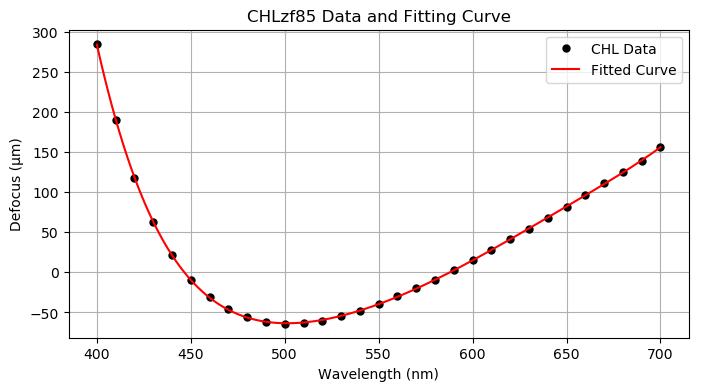

In [4]:
CHL_coeffs = np.polyfit(wl, CHLdata, 6)

def CHLFit(x):
    return np.polyval(CHL_coeffs, x)

wl_fit = np.linspace(400, 700, 300)
CHL_fit = CHLFit(wl_fit)

plt.figure(figsize=(8, 4))
plt.plot(wl, CHLdata, 'o', markersize=5, color='black', label='CHL Data')
plt.plot(wl_fit, CHL_fit, '-', color='red', label='Fitted Curve')
plt.title('CHLzf85 Data and Fitting Curve')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Defocus (µm)')
plt.legend()
plt.grid(True)
plt.show()

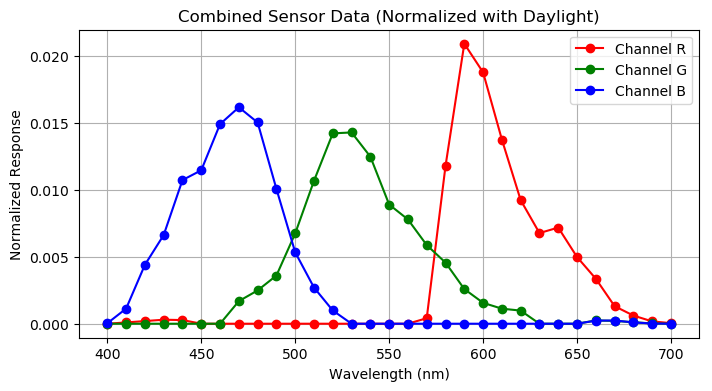

In [5]:
plt.figure(figsize=(8, 4))
channel_colors = {"R": "red", "G": "green", "B": "blue"}

for ch, color in channel_colors.items():
    plt.plot(wl, sensor_map[ch], 'o-', color=color, label= 'Channel ' f'{ch}')

plt.title('Combined Sensor Data (Normalized with Daylight)')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Normalized Response')
plt.legend()
plt.grid(True)
plt.show()

In [6]:
X_RES_P1    = 5          # Plot 1 步长 (µm)
X_RES_P2    = 1          # Plot 2 步长 (µm)
IMG_HEIGHT  = 60         # Plot 2 垂直像素行数

def update_plots(z, F, gamma, model):
    """
    1. Plot the R/G/B edge‑response curves with dashed lines marking the Farbsaum boundaries.
    2. Generate a ColorFringe pseudo‑density image.
    Also prints the chromatic‑fringe width for the specified defocus z.
    """
    psf_mode = "gauss" if model == "Gaussian-core PSF" else "disk"

    # ---------- Plot 1: ----------
    x_vals = np.arange(-XRANGE, XRANGE + X_RES_P1, X_RES_P1, dtype=float)

    edge_rgb = np.array([ColorFringe(x, z, F, gamma, CHLdata, psf_mode)
                         for x in x_vals])
    edgeR, edgeG, edgeB = edge_rgb.T

    farb_vals = np.array([Farbsaum(x, z, F, gamma, CHLdata, psf_mode)
                          for x in x_vals])

    fig = plt.figure(figsize=(12, 6))
    ax1 = fig.add_subplot(1, 2, 1)
    ax1.plot(x_vals, edgeR, label="Edge R", color="r")
    ax1.plot(x_vals, edgeG, label="Edge G", color="g")
    ax1.plot(x_vals, edgeB, label="Edge B", color="b")

    trans_idx = np.flatnonzero(np.diff(farb_vals.astype(bool), prepend=farb_vals[0]))
    for i, idx in enumerate(trans_idx):
        ax1.axvline(x_vals[idx], color="k", linestyle="--", linewidth=1,
                    label="Farb‑boundary" if i == 0 else None)

    ax1.set(xlabel="x (µm)", ylabel="Response",
            title=f"Edge Functions ({model})", ylim=(0, 1))
    ax1.legend()
    ax1.grid(True)

    # ---------- Plot 2: ----------
    X = np.arange(-XRANGE, XRANGE + X_RES_P2, X_RES_P2, dtype=float)
    img_row = np.array([ColorFringe(x, z, F, gamma, CHLdata, psf_mode) for x in X])
    img_row = np.clip(img_row, 0, 1)
    img = np.repeat(img_row[:, None, :], IMG_HEIGHT, axis=1)   # (len(X), IMG_HEIGHT, 3)

    ax2 = fig.add_subplot(1, 2, 2)
    ax2.imshow(img.swapaxes(0, 1), extent=[X.min(), X.max(), 0, IMG_HEIGHT],
               aspect="auto", origin="lower")
    ax2.set_title("Pseudo‑density fringe map")
    ax2.set_xlabel("x (µm)")
    ax2.set_yticks([])

    plt.tight_layout()
    plt.show()

    width = Farbsaumbreite(z, F, gamma, CHLdata, psf_mode)
    print(f"Color fringe width = {width} px")

interact(
    update_plots,
    z=FloatSlider(min=-defocusrange, max=defocusrange, step=defocus_step,
                  value=0, description="Defocus (µm)"),
    F=FloatSlider(min=1, max=16, step=1, value=F_VALUE,
                  description="Exposure F"),
    gamma=FloatSlider(min=1, max=3, step=0.2, value=GAMMA_VALUE,
                      description="Gamma"),
    model=RadioButtons(options=["Gaussian-core PSF", "Sharp-disk PSF"],
                       description="PSF"),
)

interactive(children=(FloatSlider(value=0.0, description='Defocus (µm)', max=650.0, min=-650.0, step=10.0), Fl…

<function __main__.update_plots(z, F, gamma, model)>

In [7]:
# ---------------------------------------------------------------------
# Defocus vector
# ---------------------------------------------------------------------
z_vals = np.arange(-defocusrange,
                   defocusrange + defocus_step,
                   defocus_step, dtype=float)

# ---------------------------------------------------------------------
# Single‑curve helper
# ---------------------------------------------------------------------
def plot_farbs(F_value: float, label: str, psf_mode: str) -> np.ndarray:
    """Return [z, CFW] samples and draw the curve."""
    data = np.array([[z,
                      Farbsaumbreite(z, F_value, GAMMA_VALUE,
                                     CHLdata, psf_mode)]
                     for z in z_vals])
    plt.plot(data[:, 0], data[:, 1], 'o-', ms=3, label=label)
    return data

# ---------------------------------------------------------------------
# Comparison plot + statistics
# ---------------------------------------------------------------------
def plot_farbs_comparison(F_values=(2,),
                          model_choice="Gaussian-core PSF") -> None:
    """Draw curves for all F‑numbers and print simple stats."""
    psf_mode = "gauss" if model_choice == "Gaussian-core PSF" else "disk"

    plt.figure(figsize=(8, 4))
    print(f"\n=== Statistics ({model_choice}) ===")
    print("F   max(width)   mean(width)")
    print("-" * 28)

    for F_val in sorted(F_values):
        data = plot_farbs(F_val, f"F = {F_val}", psf_mode)
        print(f"{F_val:<3} {data[:,1].max():>10.2f}   {data[:,1].mean():>10.2f}")

    plt.title(f"Colour‑fringe width vs. defocus — {model_choice}")
    plt.xlabel("Defocus z (µm)")
    plt.ylabel("Colour‑fringe width (pixels)")
    plt.legend()
    plt.grid(True)
    plt.show()

# ---------------------------------------------------------------------
# Interactive wrapper
# ---------------------------------------------------------------------
def interactive_plot(F_values, model_choice):
    plot_farbs_comparison(F_values=F_values, model_choice=model_choice)


F_values_widget = widgets.SelectMultiple(
    options=[1, 2, 4, 8],
    value=[1, 2, 4, 8],
    description='F values'
)
model_widget = widgets.RadioButtons(
    options=['Gaussian-core PSF', 'Sharp-disk PSF'],
    value='Gaussian-core PSF',
    description='PSF'
)

interact(interactive_plot,
         F_values=F_values_widget,
         model_choice=model_widget)


interactive(children=(SelectMultiple(description='F values', index=(0, 1, 2, 3), options=(1, 2, 4, 8), value=(…

<function __main__.interactive_plot(F_values, model_choice)>